Visualizes TIF Files in RGB with annotations. Mesteparten stjålet fra diskusjonssiden

!!! Viktig
Må inkludere path til train_images. GIT ville ikke at jeg lasta opp den filen.

In [50]:
#imports
import os
import json
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import tifffile as tiff
from scipy.interpolate import griddata
import cv2 

In [2]:
def convert_to_geojson(data):
    """
    Converts a list of dictionaries in the specified format to GeoJSON
    Args:
        data: A list of dictionaries containing 'class' and 'segmentation' keys
    Returns:
        A GeoJSON feature collection
    """
    features = []
    for item in data:
        polygon = []
        for i in range(0, len(item['segmentation']), 2):
            polygon.append([item['segmentation'][i], item['segmentation'][i+1]])
        features.append({
            "type": "Feature",
            "geometry": {
            "type": "Polygon",
            "coordinates": [polygon]
            },
            "properties": {"class": item['class']}
        })
    return { "type": "FeatureCollection", "features": features}
outfolder = 'rgb_annotation'  # Replace with your desired folder name
if not os.path.exists(outfolder):
  os.makedirs(outfolder, exist_ok=True)


In [3]:
#Farger
annotation_color_allocation = {
    'plantation' : 'red', 
    'grassland_shrubland' : 'blue', 
    'mining' : 'orange',
    'logging' : 'green',
}   

In [5]:
#laste inn annotations fra JSON og bilder fra fil
parent_dir = os.path.split(os.getcwd())[0]
#print(parent_dir)
TRAIN_IMAGES_PATH=parent_dir+"/train_images"
#print(TRAIN_IMAGES_PATH)
train_image_num = len(os.listdir(TRAIN_IMAGES_PATH))
print(f"Number of train images: {train_image_num}") #176
# plot and save RGB with annotation
with open('train_annotations.json', 'r') as file:
    train_annotations = json.load(file)


Number of train images: 176


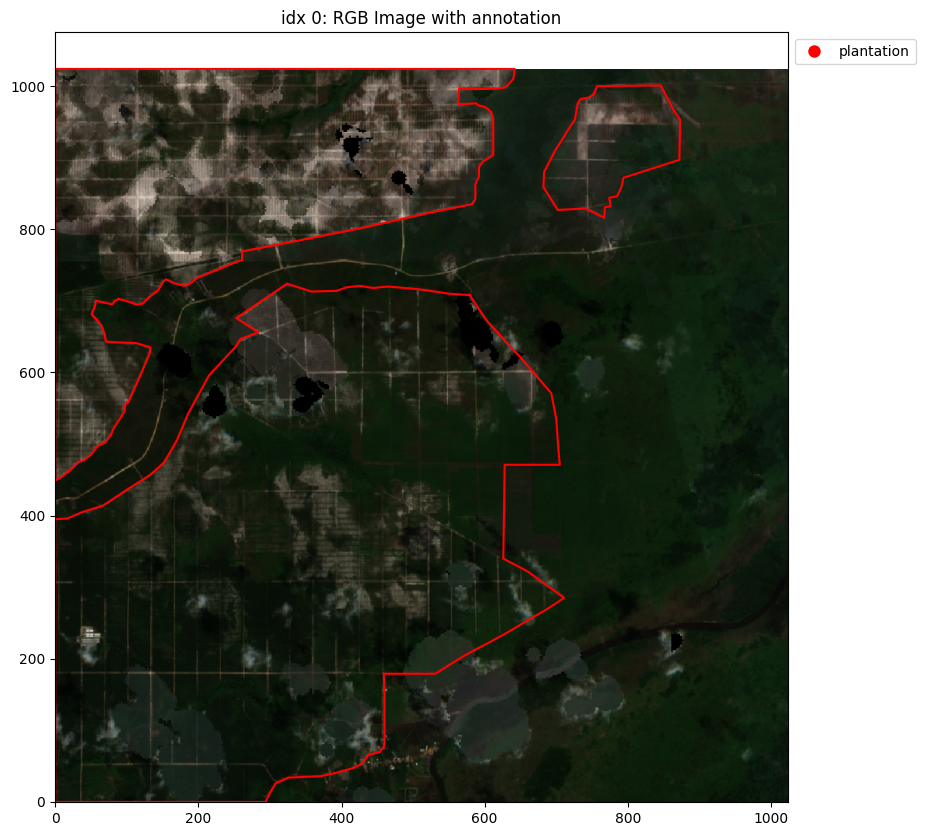

In [19]:
#Velg train_image_num for alle bilder
#n=train_image_num
n=1
for index_for_train_image in range(n):
    filename = os.path.join(outfolder, f'rgb_with_annotation_{index_for_train_image}.png')
    if os.path.exists(filename):
        print(f"File {filename} already exists. Skipping.")
        continue
    # Visualize sample tif data
    SAMPLE_TIF_PATH = f'{TRAIN_IMAGES_PATH}/train_{index_for_train_image}.tif'
    annotation_data = train_annotations['images']
    id_to_annotation = {item['file_name']: item for item in annotation_data}
    annotation_data = id_to_annotation[ f'train_{index_for_train_image}.tif']['annotations']

    #annotation_data = train_annotations['images'][index_for_train_image]['annotations']
    
    # Convert to GeoJSON
    geojson_data = convert_to_geojson(annotation_data)
    gdf = gpd.GeoDataFrame.from_features(geojson_data)
    # Open sample tif file
    with rasterio.open(SAMPLE_TIF_PATH) as src:
        # Read bands 2, 3, and 4 (B, G, R)
        b2 = src.read(2)
        b3 = src.read(3)
        b4 = src.read(4)
        #Checking that all bands have the same shape (1024,1024)
        #for band in range(1,13):
        #    print(band, src.read(band).shape)
        # Stack bands to create a 3D array (height, width, channels)
        rgb_image = np.dstack((b4, b3, b2))

        rgb_image = np.nan_to_num(rgb_image) # Replace NaN and inf with 0

        # Normalize pixel values for display
        rgb_image = rgb_image.astype(np.float32)
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        rgb_image = np.clip(rgb_image, 0, 1) # Clip values to 0-1 range for floats

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(rgb_image)
        ax.invert_yaxis()
        
        for idx in range(len(gdf)):
            # print(gdf.iloc[idx]['class'])
            gdf.iloc[[idx]].boundary.plot(ax=ax, color=annotation_color_allocation[gdf.iloc[idx]['class']])

        # Create and add custom legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                                    markerfacecolor=value, markersize=10) 
                            for key, value in annotation_color_allocation.items() 
                            if key in gdf['class'].unique()]
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

        # gdf.boundary.plot(ax=ax, color='red')
        plt.title(f'idx {index_for_train_image}: RGB Image with annotation')

        #Om man vil lagre
        #plt.savefig(filename)
        #plt.show()

In [7]:
#Data exploration on annotations:
overview_annotations={"plantation" : 0,"grassland_shrubland":0,"logging":0,"mining":0}
for single_annotation in train_annotations["images"]:
    
    for polygon  in  single_annotation["annotations"]:
        overview_annotations[polygon["class"]]+=1
    
print(overview_annotations)


    

{'plantation': 648, 'grassland_shrubland': 764, 'logging': 395, 'mining': 459}


In [53]:
#Examining NaN values in the tif files

def analyze_nans(tif_path):
    """Analyze NaN distribution in TIF file"""
    with rasterio.open(tif_path) as src:
        data = src.read()
        meta = src.meta.copy()
        nan_mask = np.isnan(data)
        stats = {
            'total_pixels': data.size,
            'nan_count': np.count_nonzero(nan_mask),
            'nan_percentage': (np.count_nonzero(nan_mask)/data.size)*100
        }
    return data, meta, stats

def fill_nans(data, method='interpolate', **kwargs):
    """Fill NaN values using specified method."""
    filled_data = np.zeros_like(data)
    
    for b in range(data.shape[0]):  # Iterate over bands
        band = data[b].copy()
        mask = np.isnan(band).astype(np.uint8)
        
        if method == 'opencv_inpaint_telea':
            # Replace NaNs with 0 for inpainting
            band[mask == 1] = 0
            filled = cv2.inpaint(
                band.astype(np.float32),
                mask * 255,
                inpaintRadius=kwargs.get('inpaint_radius', 3),
                flags=cv2.INPAINT_TELEA
            )
        elif method == 'opencv_inpaint_ns':
            band[mask == 1] = 0
            filled = cv2.inpaint(
                band.astype(np.float32),
                mask * 255,
                inpaintRadius=kwargs.get('inpaint_radius', 3),
                flags=cv2.INPAINT_NS
            )
        elif method == 'nearest':
            # SciPy's nearest neighbor interpolation
            points = np.argwhere(~np.isnan(band))
            values = band[~np.isnan(band)]
            grid = np.indices(band.shape).reshape(2, -1).T
            filled = griddata(points, values, grid, method='nearest').reshape(band.shape)
        else:
            raise ValueError(f"Unsupported method: {method}")
        
        filled_data[b] = filled
    
    return filled_data


def process_tif(input_path, output_path, method='interpolate'):
    """Process TIF file and save result"""
    data, meta, stats = analyze_nans(input_path)
    if stats['nan_count'] > 0:
        data = fill_nans(data, method)
        
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(data)
    return stats

def visualize_nan_filling(tif_path, band=1, method='opencv_inpaint_telea'):
    """Visualize NaN filling results for a specific band."""
    with rasterio.open(tif_path) as src:
        original = src.read(band)
    
    # Process the band
    filled = fill_nans(original[np.newaxis, ...], method=method)[0]  # Add band dim
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(original, cmap='viridis')
    ax1.set_title('Original with NaNs')
    plt.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(filled, cmap='viridis')
    ax2.set_title(f'After {method} Filling')
    plt.colorbar(im2, ax=ax2)
    
    plt.suptitle(f'NaN Filling Results - Band {band}')
    plt.tight_layout()
    output_png = tif_path.replace('.tif', '_comparison.png')
    plt.savefig(output_png)
    plt.show()
    return output_png

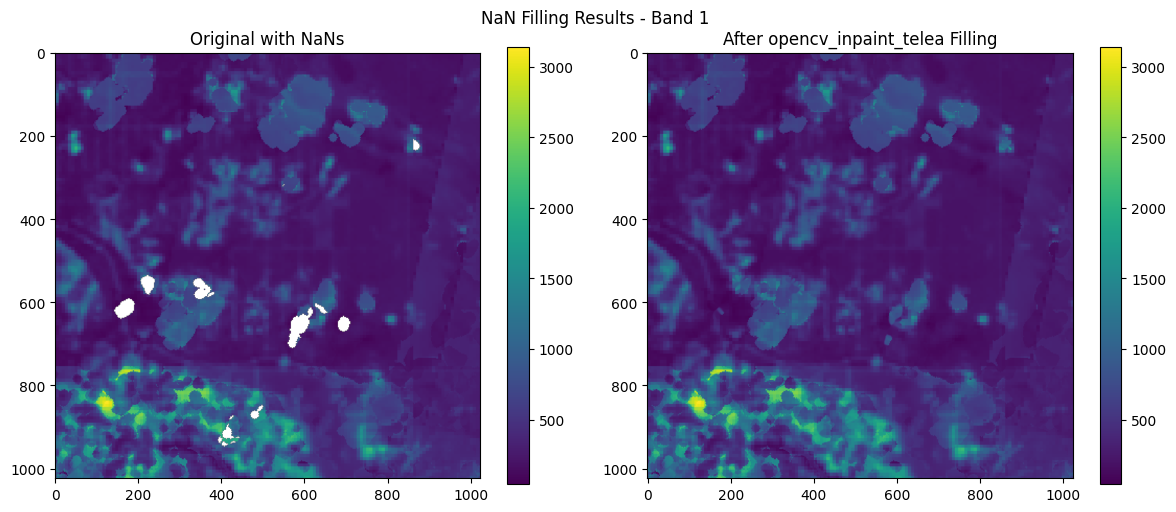

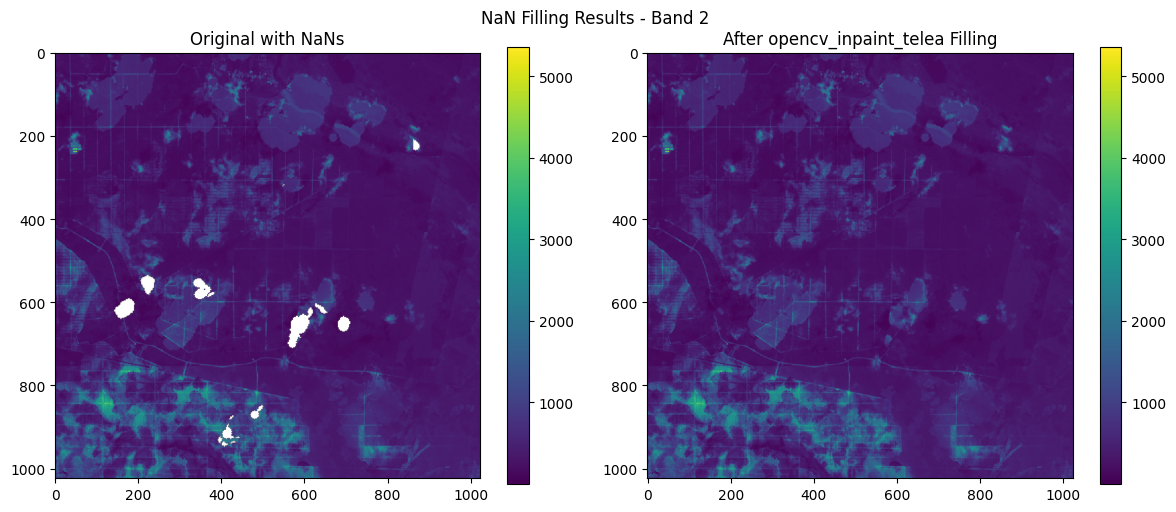

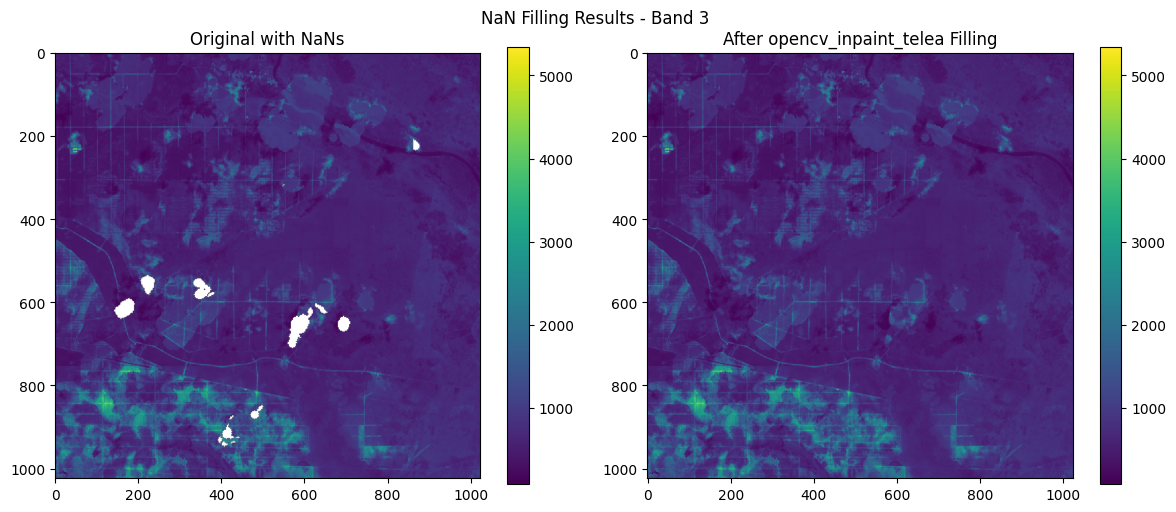

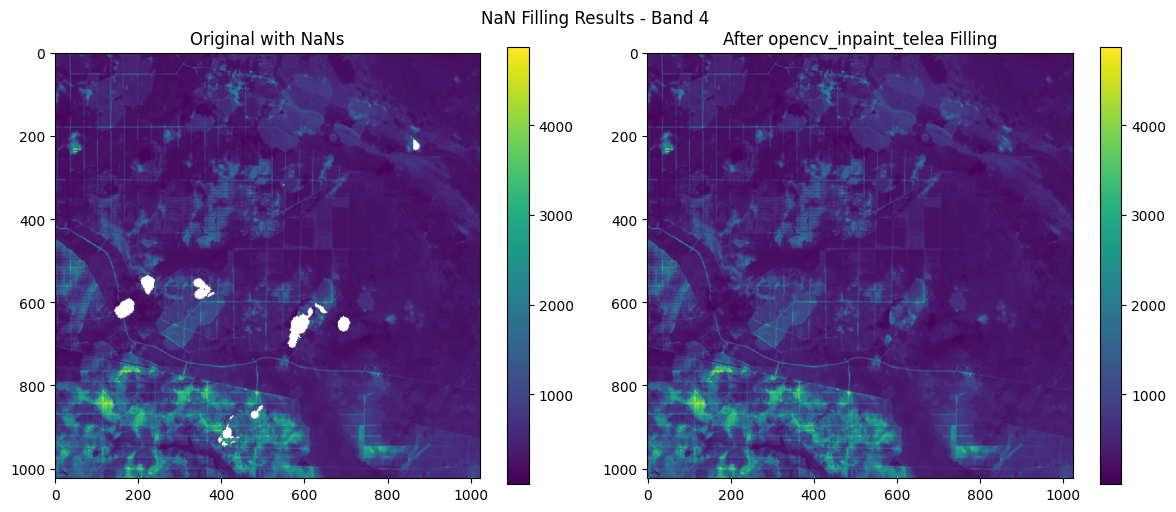

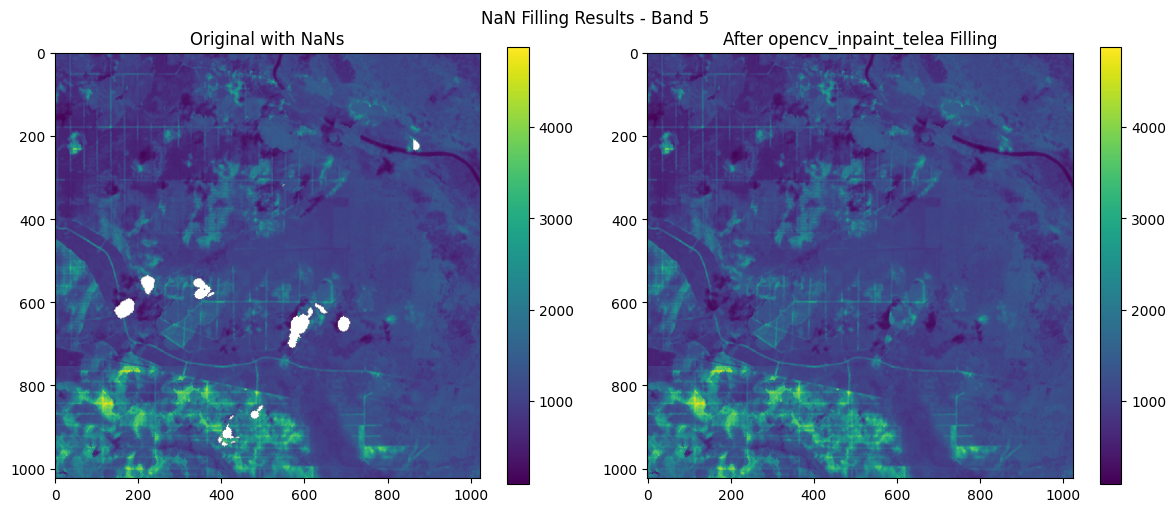

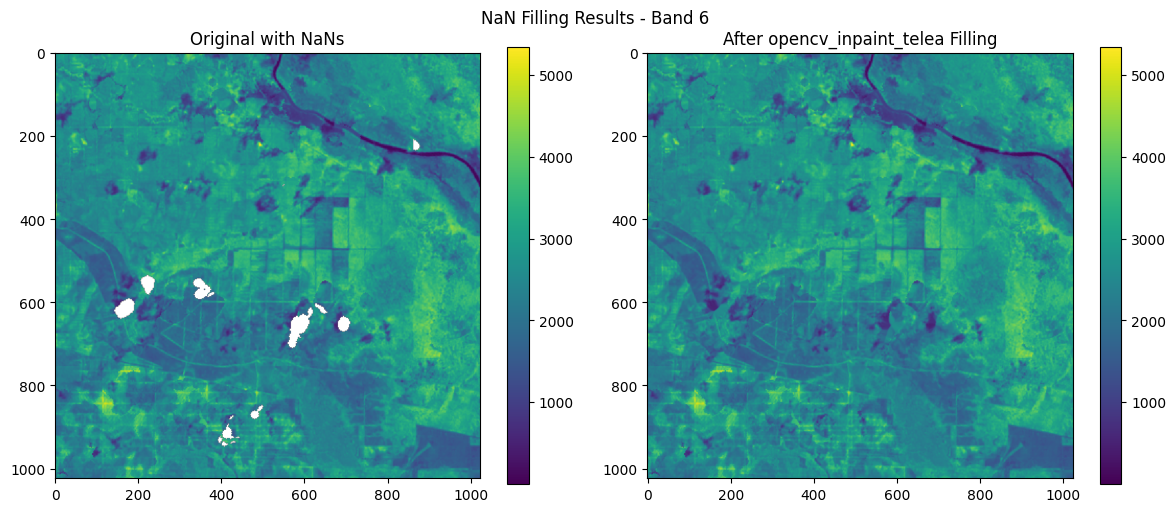

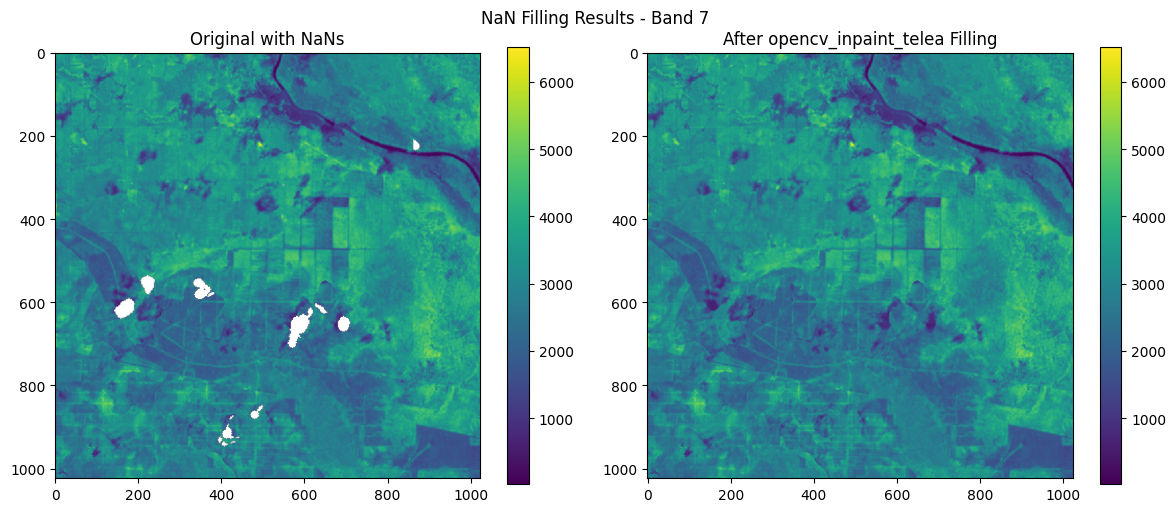

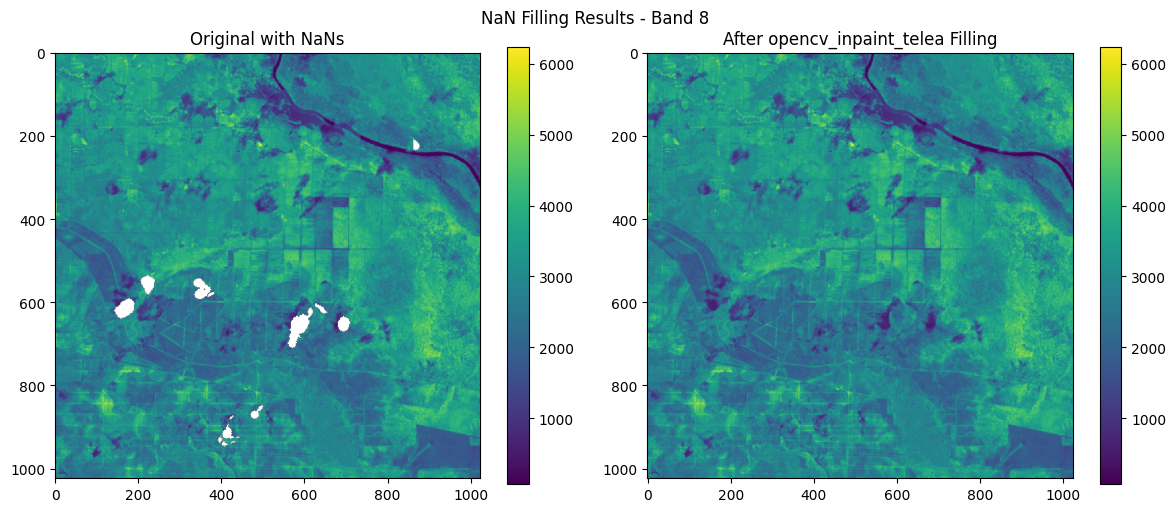

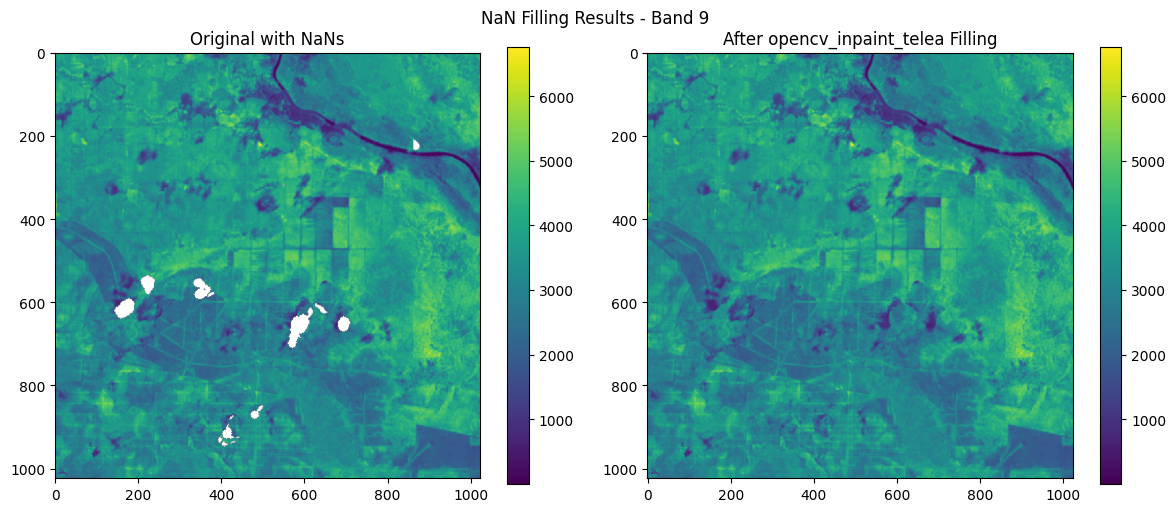

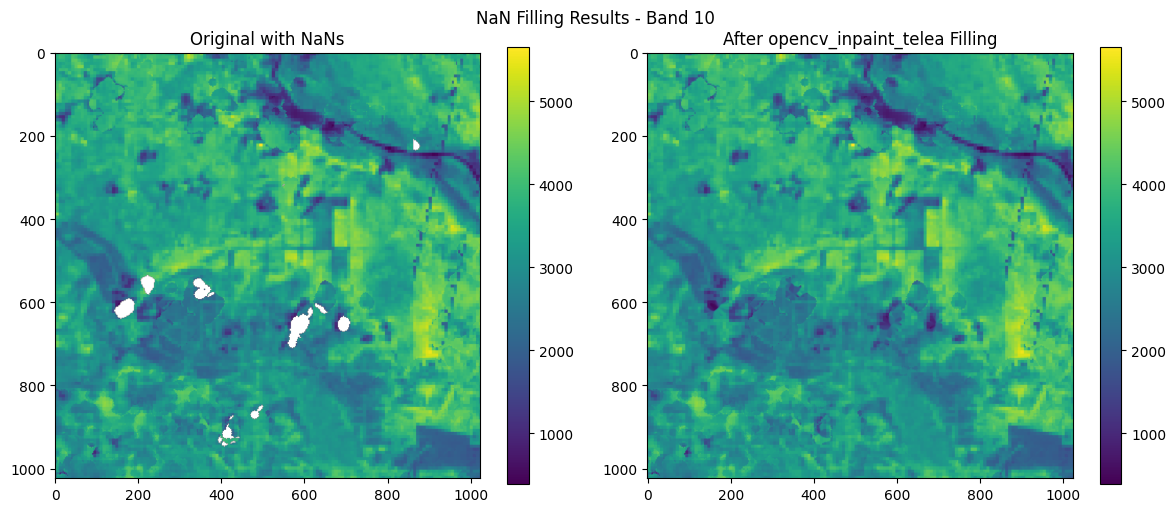

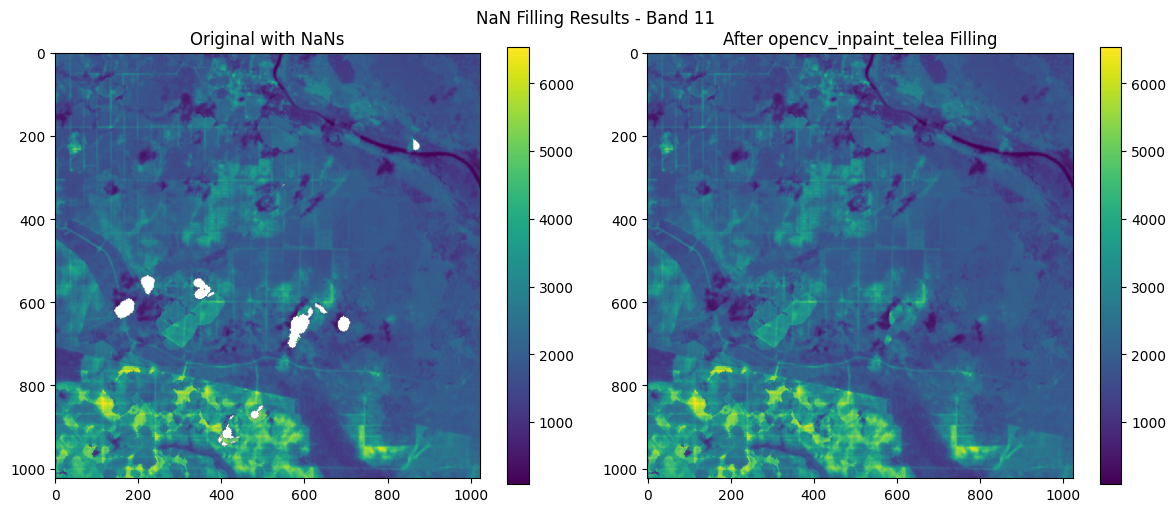

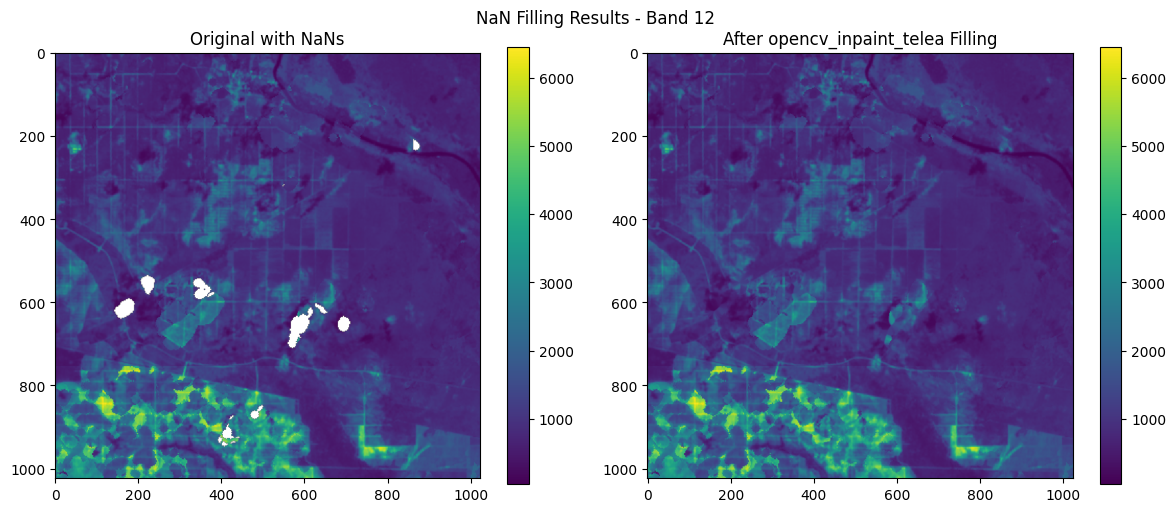

In [54]:
for i in range(1, 13):
    visualize_nan_filling(SAMPLE_TIF_PATH, band=i)